##### General comments
> Justify why do we choose each model, also, generate a rank of our evaluation for all the models to choose the best one for our problem. i.e, Support Vector Machines', 'KNN', 'Logistic Regression', 'Random Forest', 'Naive Bayes', 'Perceptron', 'Grad boost','Decision Tree'

> Justify VERY WELL why do we choose each component and why do we keep the other ones, and know the impact for each one

> Justify very well why do we make reduction and then pca (both reduction of dimensionality)

> Make a diagram for the code

> Hyperparameters, Put in comments or in markdown text the values of each one, and justify (if we choose a lower or higher value, argument), preference graph the accuracy with each hyperparameter setting

> add more axis names 


# ETL Process

Import Libraries

In [271]:
import pandas as pd
#Pandas is a fast, powerful, flexible and easy to use open source data analysis and data manipulation library built on top of the Python programming language.
import numpy as np
#NumPy is a library for the Python programming language, adding support for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
import matplotlib.pyplot as plt
#Matplotlib is a plotting library for the Python programming language and its numerical mathematics extension NumPy.
from sklearn.decomposition import PCA
#Principal component analysis (PCA) is a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables into a set of values of linearly uncorrelated variables called principal components.
from sklearn.preprocessing import StandardScaler, LabelEncoder
#StandardScaler standardizes features by removing the mean and scaling to unit variance
import seaborn as sns
#Seaborn is a Python data visualization library based on matplotlib. It provides a high-level interface for drawing attractive and informative statistical graphics.
from scipy import stats
#SciPy is a free and open-source Python library used for scientific and technical computing. SciPy contains modules for optimization, linear algebra, integration, interpolation, special functions, FFT, signal and image processing, ODE solvers and other tasks common in science and engineering.
from statsmodels.graphics.gofplots import qqplot
#The Q-Q plot, or quantile-quantile plot, is a graphical tool to help us assess if a set of data plausibly came from some theoretical distribution such as a Normal or exponential.
from sklearn.linear_model import LogisticRegression
#Logistic regression is a statistical model that in its basic form uses a logistic function to model a binary dependent variable, although many more complex extensions exist.
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
#Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True and how many are False. More specifically, True Positives, False Positives, True Negatives and False Negatives are used to predict the metrics of a classification report.
from sklearn.model_selection import train_test_split, GridSearchCV
#Split arrays or matrices into random train and test subsets
from sklearn.model_selection import cross_val_score, StratifiedKFold
#Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into.
from sklearn.tree import DecisionTreeClassifier
#A decision tree is a flowchart-like tree structure where an internal node represents a feature(or attribute), the branch represents a decision rule, and each leaf node represents the outcome.
from sklearn.ensemble import RandomForestClassifier
#Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operate by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes of the individual trees.
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#Classification report is used to measure the quality of predictions from a classification algorithm. How many predictions are True and how many are False. More specifically, True Positives, False Positives, True Negatives and False Negatives are used to predict the metrics of a classification report.
from sklearn.svm import SVC
#Support vector machines (SVMs) are a set of supervised learning methods used for classification, regression and outliers detection.
from sklearn.model_selection import GridSearchCV
#Grid search is the process of performing hyper parameter tuning in order to determine the optimal values for a given model.
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.metrics import roc_auc_score

%matplotlib inline 

Load dataset

In [202]:
s3_url_train = "https://gatitoenamoraobucket.s3.amazonaws.com/titanic/train.csv"
#We download the data from the S3 bucket
data_frame = pd.read_csv(s3_url_train)
#We read the data from the csv file and store it in a data frame

s3_url_test = "https://gatitoenamoraobucket.s3.amazonaws.com/titanic/test.csv"
#We download the data from the S3 bucket
data_frame_test = pd.read_csv(s3_url_test)

survived_url_test = "https://gatitoenamoraobucket.s3.amazonaws.com/titanic/gender_submission.csv"
#We download the data from the S3 bucket
data_frame_survived = pd.read_csv(survived_url_test)
#We read the data from the csv file and store it in a data frame

Show features from dataset

In [203]:
data_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Now that we see this, we can conclude that

- Numerical: PassengerId, Survived, Pclass, Age, Sibsp, Parch, Fare
    - Continous: Age, PassengerId, SibSp, Parch, Fare
    - Discrete: Survived, Pclass
- Categorical: Name, Sex, Ticket, Cabin, Embarked

What does it mean each piece of code:

- Passenger ID: A unique identifier for each passenger
- Survived: Whether the passenger survived (1 = Survived, 0 = Did not survive)
- Pclass: The passenger's class on the ship (1 = 1st class, 2 = 2nd class, 3 = 3rd class). -> It represents socio-economic status
- Name: The name of the passenger
- Sex: The gender of the passenger (Male/Female)
- Age: The age of the passenger in years.
- SibSp: The number of siblings or spouses the passenger had aboard
- Parch: The number of parents or children the passenger had aboard
- Ticket: The ticket number of the passenger (dropped in your version)
- Fare: The amount of money the passenger paid for the ticket
- Cabin: The cabin number the passenger stayed in
- Embarked: The port where the passenger boarded the Titanic (C = Cherbourg, Q = Queenstown, S = Southampton).

In [204]:
data_frame.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


What can we conclude for this?

- Diferent number of values available
    - Age has 714 registers, but the other ones have 891
- Mean of the age that people who were on the titanic was 30

In [205]:
data_frame.describe(include=['object'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,347082,G6,S
freq,1,577,7,4,644


What can we conclude from this?

- As it was said before, we can see that there is only 204 data from the cabin, a very low number compared to the other ones
- There is only 2 missing values from Embarked
- There is not duplicated names
- Most part of the people who embarked, have the letter 'S' (Southampton) -> Evident indicator for mode in where they embarked

In [206]:
print(data_frame.columns.values)

['PassengerId' 'Survived' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch'
 'Ticket' 'Fare' 'Cabin' 'Embarked']


In [207]:
print(data_frame_test.columns.values)

['PassengerId' 'Pclass' 'Name' 'Sex' 'Age' 'SibSp' 'Parch' 'Ticket' 'Fare'
 'Cabin' 'Embarked']


In [208]:
print(data_frame_survived.columns.values)

['PassengerId' 'Survived']


See the structure of the dataset

In [209]:
#Print the first 5 rows of the data set
data_frame.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


We can conclude from here that a lot of the cabin values are missing

See the total numbers of missing data

In [210]:
data_frame.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Correlacionar PClass con Cabin 

Se decide justificar por ese lado 

As we saw, the cabin is the most quantity of missing values

C:\Users\danyO\AppData\Local\Temp\ipykernel_20192\497907641.py:26: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_frame['Fare'], kde=True,ax=axes[1,2])
C:\Users\danyO\AppData\Local\Temp\ipykernel_20192\497907641.py:30: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_frame['Age'].dropna(),

Text(0.5, 0, 'People')

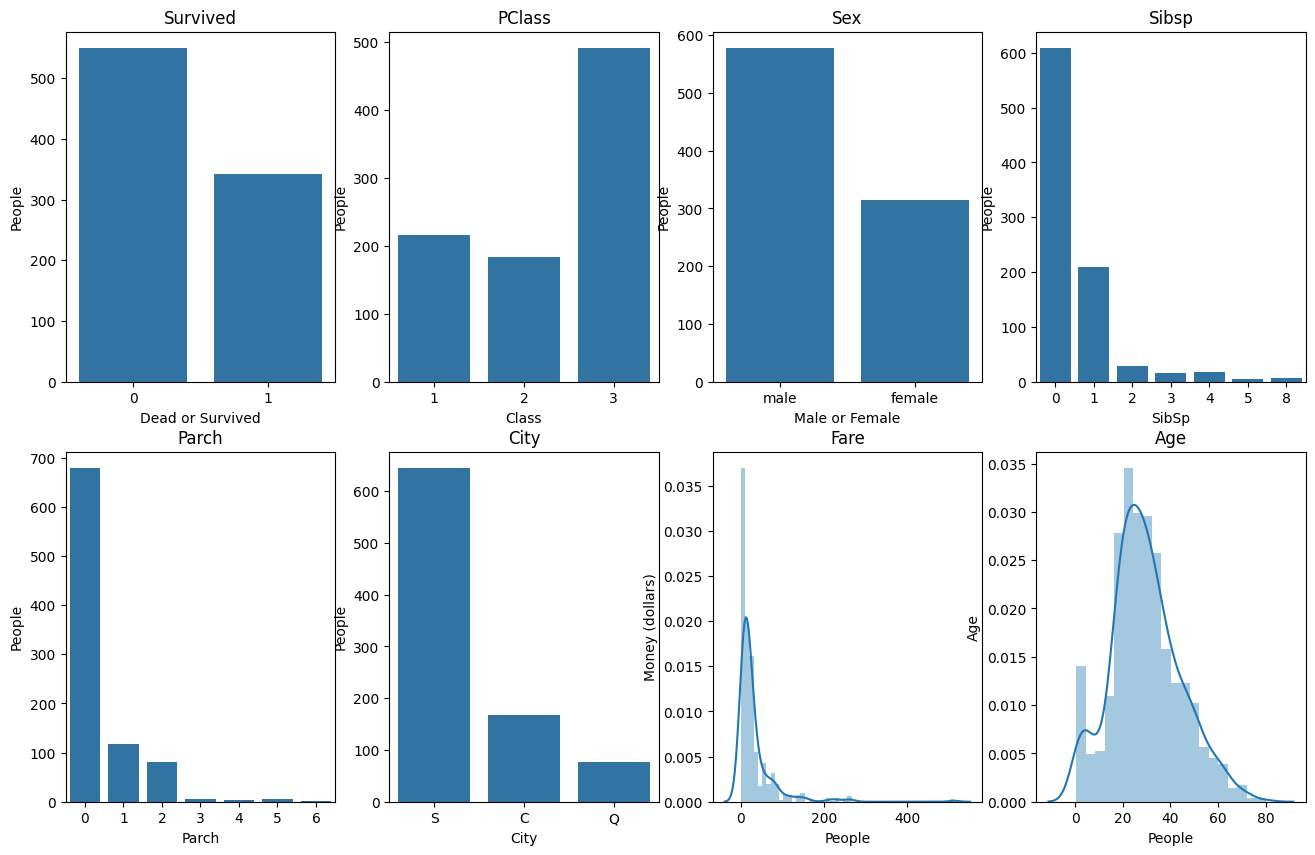

In [211]:
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
sns.countplot(x='Survived',data=data_frame,ax=axes[0,0])
axes[0,0].set_title("Survived")
axes[0,0].set_ylabel("People")
axes[0,0].set_xlabel("Dead or Survived")
sns.countplot(x='Pclass',data=data_frame,ax=axes[0,1])
axes[0,1].set_title("PClass")
axes[0,1].set_ylabel("People")
axes[0,1].set_xlabel("Class")
sns.countplot(x='Sex',data=data_frame,ax=axes[0,2])
axes[0,2].set_title("Sex")
axes[0,2].set_ylabel("People")
axes[0,2].set_xlabel("Male or Female")
sns.countplot(x='SibSp',data=data_frame,ax=axes[0,3])
axes[0,3].set_title("Sibsp")
axes[0,3].set_ylabel("People")
axes[0,3].set_xlabel("SibSp")
sns.countplot(x='Parch',data=data_frame,ax=axes[1,0])
axes[1,0].set_title("Parch")
axes[1,0].set_ylabel("People")
axes[1,0].set_xlabel("Parch")
sns.countplot(x='Embarked',data=data_frame,ax=axes[1,1])
axes[1,1].set_title("City")
axes[1,1].set_ylabel("People")
axes[1,1].set_xlabel("City")
sns.distplot(data_frame['Fare'], kde=True,ax=axes[1,2])
axes[1,2].set_title("Fare")
axes[1,2].set_ylabel("Money (dollars)")
axes[1,2].set_xlabel("People")
sns.distplot(data_frame['Age'].dropna(),kde=True,ax=axes[1,3])
axes[1,3].set_title("Age")
axes[1,3].set_ylabel("Age")
axes[1,3].set_xlabel("People")

We can conclude here a few new discoverments and reaffirm previous points

- Low percentage of survivors
- Huge difference in pclass passengers (1, 2 and 3) -> This indicates is an important variable
- We have more male passengers
- Almost all the passengers dont have siblings or parch
- Almost all people come from Southamption
- We see a great relationship between fare and PClass because there are related (more fare, best Pclass) -> Both vars try to said the same
- Mean of age of 30

Text(0, 0.5, 'People')

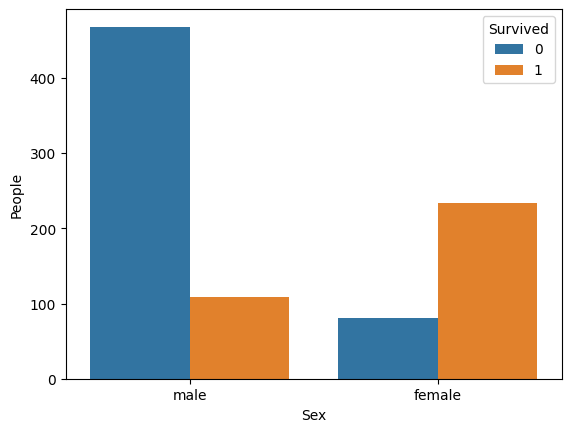

In [212]:
sns.countplot(x='Sex', hue='Survived', data=data_frame)
plt.ylabel('People')

We can conclude from this that from the male side there is a big difference ratio of survivance from the female side

For that, this is an important **attribute**

Text(0.5, 0, 'Survived')

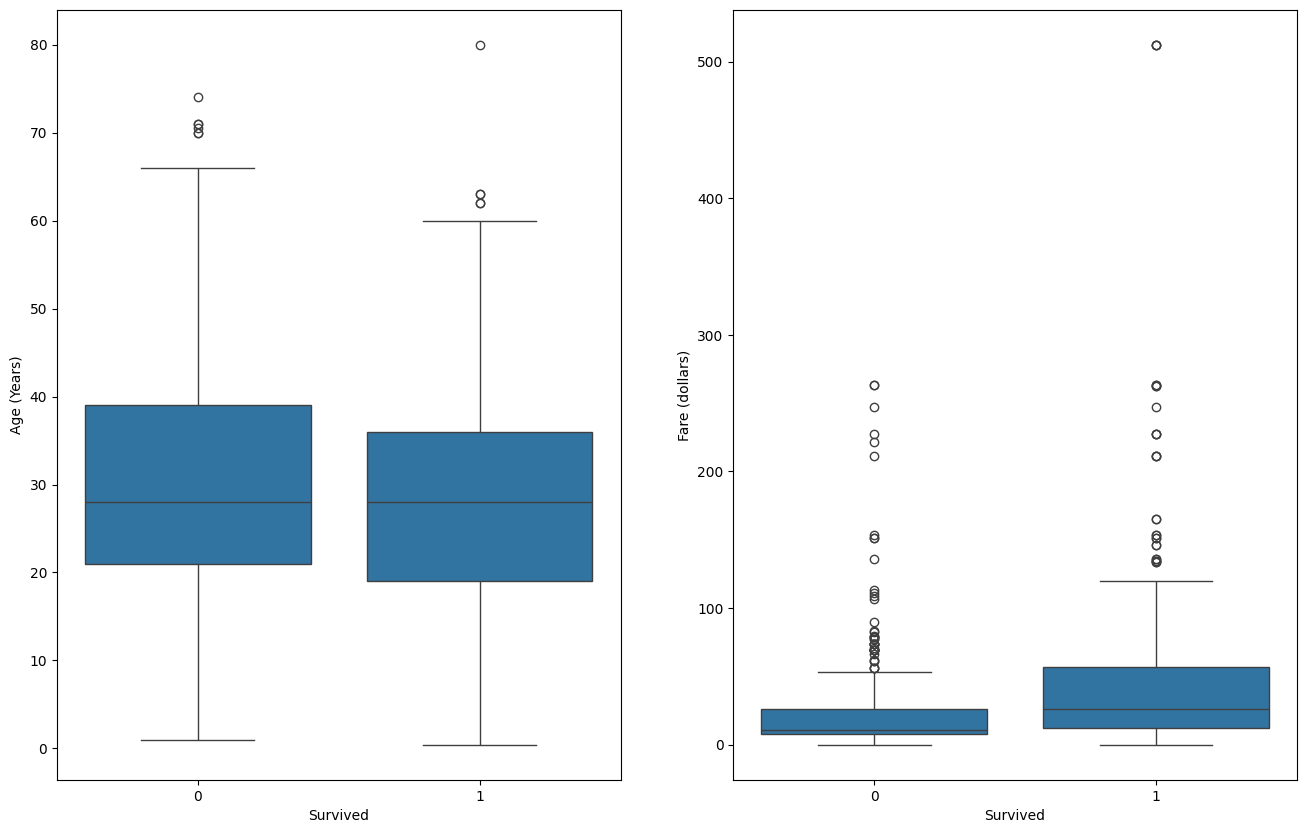

In [213]:
figbi, axesbi = plt.subplots(1, 2, figsize=(16, 10))
sns.boxplot(x="Survived", y="Age", data=data_frame,ax=axesbi[0])
axesbi[0].set_ylabel("Age (Years)")
axesbi[0].set_xlabel("Survived")

sns.boxplot(x="Survived", y="Fare", data=data_frame,ax=axesbi[1])
axesbi[1].set_ylabel("Fare (dollars)")
axesbi[1].set_xlabel("Survived")


We can conclude from here:

- Just a few outliers from older people
- Cause of the IQR is similar, that told us that the age is not a determinant data for the survivors
- Passengers for first class, had more survivance probability
- Younger people survived more

Text(0, 0.5, 'People')

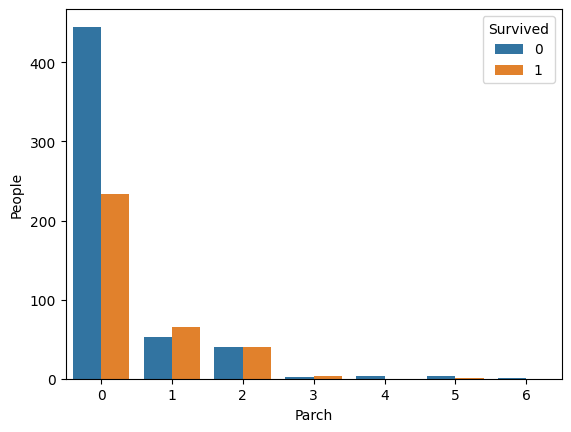

In [214]:
sns.countplot(x='Parch', hue='Survived', data=data_frame)
plt.ylabel('People')

We can conclude from here, that if the number of parch is 0, youll have less probability to survive, so we are making this binary

Text(0, 0.5, 'People')

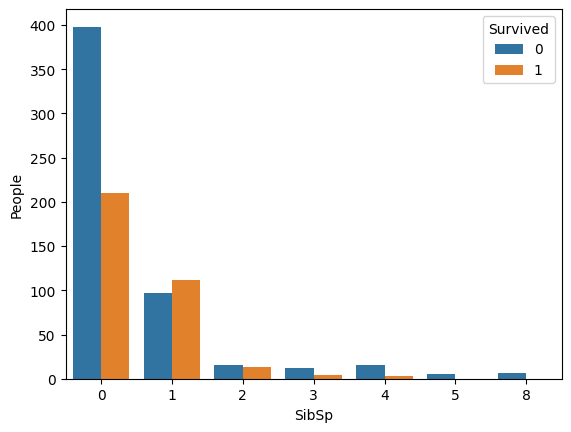

In [215]:
sns.countplot(x='SibSp', hue='Survived', data=data_frame)
plt.ylabel('People')


We can conclude from here, that if the number of Sibsp is 0 or higher than 5, youll have less probability to survive

In [216]:
col_companions=data_frame['SibSp']+data_frame['Parch']
data_frame['companions']=col_companions
col_companions_test=data_frame_test['SibSp']+data_frame_test['Parch']
data_frame_test['companions']=col_companions_test


Text(0, 0.5, 'People')

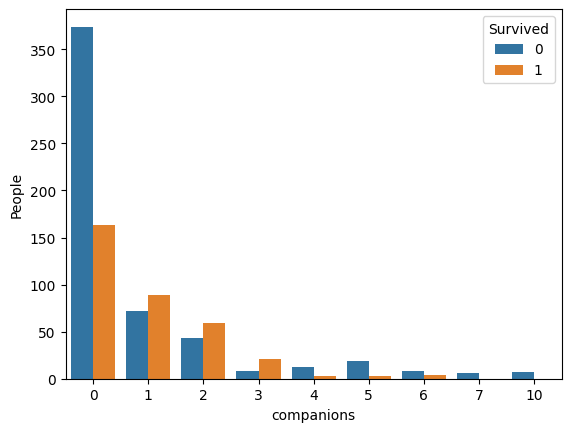

In [217]:

sns.countplot(x='companions', hue='Survived', data=data_frame)
plt.ylabel('People')


We generate this new feature because as we saw in previous graphs, both are correlated and also srepresent the same thing, if you dont have companion, you'll have more disposure to not survive

In [218]:
data_frame_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,companions
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,2


In [219]:
data_frame_survived.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


## Feature Engineering

See all caracteristics from the data

In [ ]:
#Pandas profiling on the data frame
from ydata_profiling import ProfileReport
profile = ProfileReport(data_frame, title="Pandas Profiling Report")
#We create a profile report of the data frame
profile
#The profile report gives us a detailed analysis of the data frame

In [ ]:
profile_test = ProfileReport(data_frame_test, title="Pandas Profiling Report")
#We create a profile report of the data frame
profile_test

In [ ]:
profile_survived = ProfileReport(data_frame_survived, title="Pandas Profiling Report")
#We create a profile report of the data frame

profile_survived

Encode all the data

In [220]:
le = LabelEncoder()
#We create a label encoder object
data_frame['Sex'] = le.fit_transform(data_frame['Sex']) # male = 1, female = 0
#We encode cabin
data_frame['Cabin'] = le.fit_transform(data_frame['Cabin'].astype(str))
#We encode ticket
data_frame['Ticket'] = le.fit_transform(data_frame['Ticket'].astype(str))
#We encode embarked
data_frame['Embarked'] = le.fit_transform(data_frame['Embarked'].astype(str))

le_test = LabelEncoder()
#We create a label encoder object

data_frame_test["Sex"] = le_test.fit_transform(data_frame_test['Sex']) # male = 1, female = 0
#We encode cabin
data_frame_test['Cabin'] = le_test.fit_transform(data_frame_test['Cabin'].astype(str))
#We encode ticket
data_frame_test['Ticket'] = le_test.fit_transform(data_frame_test['Ticket'].astype(str))
#We encode embarked
data_frame_test['Embarked'] = le_test.fit_transform(data_frame_test['Embarked'].astype(str))

In [221]:
original_embarked = le.inverse_transform(data_frame['Embarked'])
original_embarked
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Print the mapping in a clear format
for original_value, encoded_value in label_mapping.items():
    print(f"Original Value: '{original_value}'  --> Encoded Value: {encoded_value}")

#In further steps we will replace 3 with the mode of the column

Original Value: 'C'  --> Encoded Value: 0
Original Value: 'Q'  --> Encoded Value: 1
Original Value: 'S'  --> Encoded Value: 2
Original Value: 'nan'  --> Encoded Value: 3


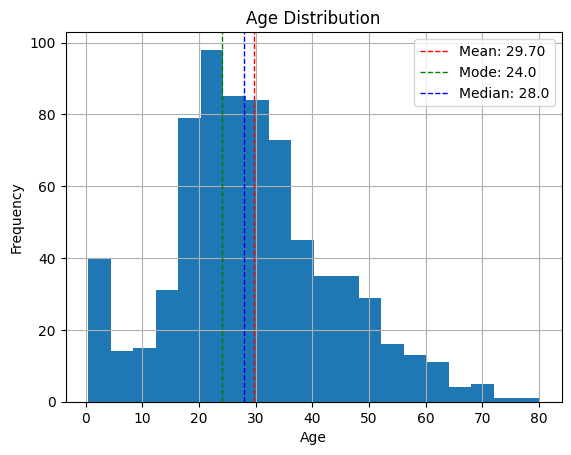

In [222]:
#We calculate the mean, mode, and median of the 'Age' column
mean_age = data_frame['Age'].mean()
mode_age = data_frame['Age'].mode()[0]
median_age = data_frame['Age'].median()

data_frame['Age'].hist(bins=20)

# Add vertical lines for mean, mode, and median
plt.axvline(mean_age, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_age:.2f}')
plt.axvline(mode_age, color='g', linestyle='dashed', linewidth=1, label=f'Mode: {mode_age}')
plt.axvline(median_age, color='b', linestyle='dashed', linewidth=1, label=f'Median: {median_age}')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.legend()  # Show the legend for the lines
plt.show()

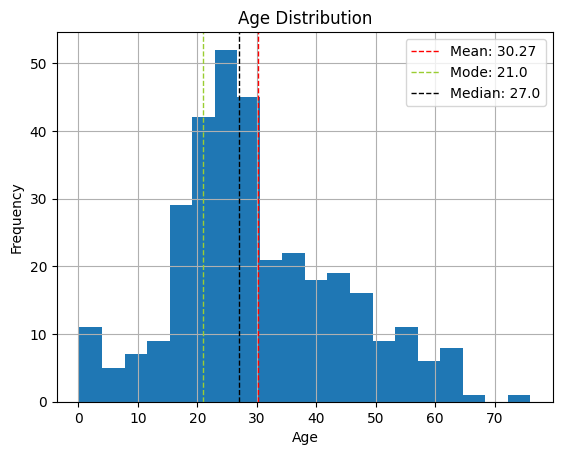

In [223]:
mean_age_test = data_frame_test['Age'].mean()
mode_age_test = data_frame_test['Age'].mode()[0]
median_age_test = data_frame_test['Age'].median()

data_frame_test['Age'].hist(bins=20)

# Add vertical lines for mean, mode, and median
plt.axvline(mean_age_test, color='r', linestyle='dashed', linewidth=1, label=f'Mean: {mean_age_test:.2f}')
plt.axvline(mode_age_test, color='yellowgreen', linestyle='dashed', linewidth=1, label=f'Mode: {mode_age_test}')
plt.axvline(median_age_test, color='black', linestyle='dashed', linewidth=1, label=f'Median: {median_age_test}')

plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.legend()  # Show the legend for the lines

plt.show()

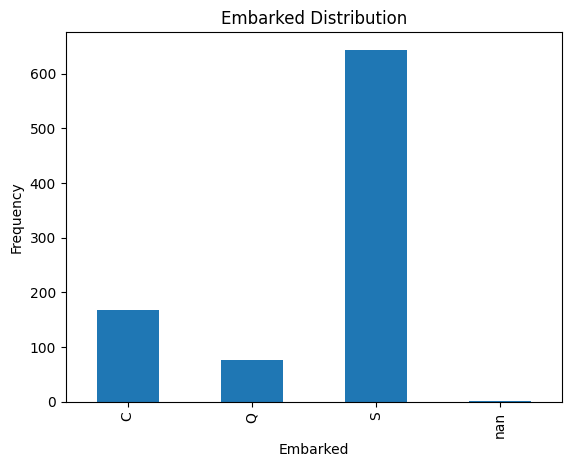

In [224]:
#We count the frequency of the 'Embarked' column and put the letter instead of the number
plt_col = data_frame['Embarked'].value_counts().sort_index()

plt_col.index = le.inverse_transform(plt_col.index)
plt_col.plot(kind='bar')

plt.xlabel('Embarked')
plt.ylabel('Frequency')
plt.title('Embarked Distribution')
plt.show()


<Axes: xlabel='Embarked', ylabel='count'>

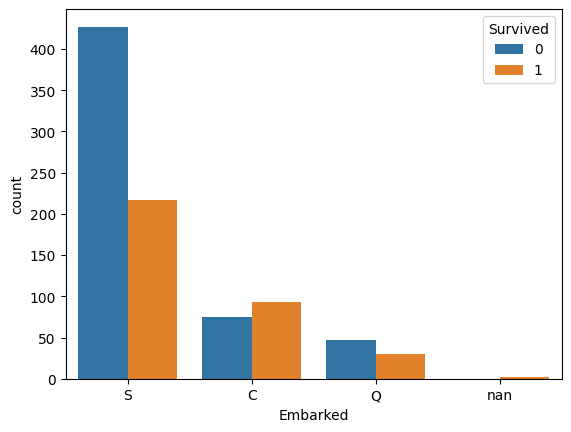

In [225]:
#transform embarked to letters again

label_mapping_inverse = {v: k for k, v in label_mapping.items()}
data_frame_copy = data_frame.copy()
data_frame_copy['Embarked'] = data_frame_copy['Embarked'].map(label_mapping_inverse).fillna('nan')
sns.countplot(x='Embarked', hue='Survived', data=data_frame_copy)

Generate correlation matrix

In [226]:
data_frame

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,companions
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,523,7.2500,147,2,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,596,71.2833,81,0,1
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,669,7.9250,147,2,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,49,53.1000,55,2,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,472,8.0500,147,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27.0,0,0,101,13.0000,147,2,0
887,888,1,1,"Graham, Miss. Margaret Edith",0,19.0,0,0,14,30.0000,30,2,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,NaN,1,2,675,23.4500,147,2,3
889,890,1,1,"Behr, Mr. Karl Howell",1,26.0,0,0,8,30.0000,60,0,0


In [227]:
#We drop name since it is not relevant
data_frame.drop(['Name'], axis=1, inplace=True)
data_frame_test.drop(['Name'], axis=1, inplace=True)

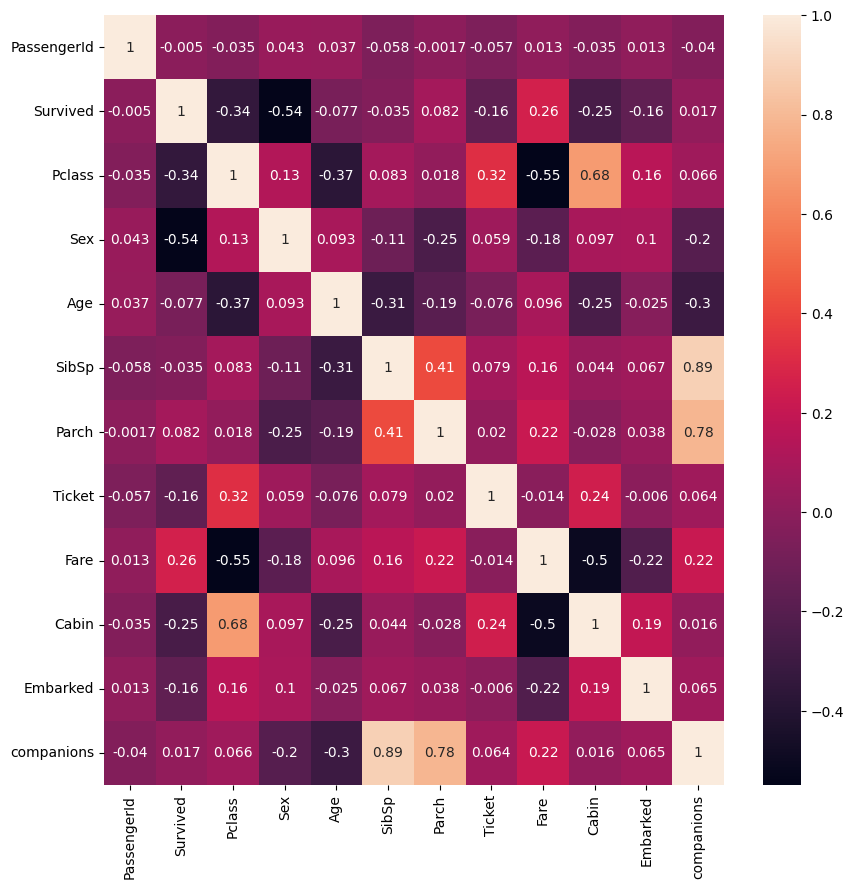

In [228]:
#we generate a correlation matrix
corr = data_frame.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr, annot=True)
plt.show()

We can conclude from here, the following:

- Pclass has a lot of correlation with Fare, wich supports what we saw before
- Age have a good correlation with PClass, SibSp
- Sibsp have a good correlation with age and parch (curious)
- Parch have a good correlation with sib and fare
- We can see a strong negative correlation of -0.55 between Pclass and Fare, so we are removing Fare.
- Also we can see a great positive correlation between Cabin and Pclass so we are removing Cabin too.
- We see a strong correlation between Ticket and Pclass, so it's out too.
- SibSp and Parch have low correlation with all other variables, so we are moving them out.
- Pclass is high related with ticket and cabin, so we can prescend of them

In [229]:
#Sum the correlation of the columns with Parch and SibSp and companions columns
correlations = data_frame.corr()['Parch'].abs()
correlations2 = data_frame.corr()['SibSp'].abs()
correlations5= data_frame.corr()['companions'].abs()

print(sum(correlations5))

3.6612891592659604


Drop unecesary columns

In [230]:
data_frame = data_frame.drop(columns=['PassengerId', 'Ticket', 'Cabin','SibSp','Parch', 'Fare'])
data_frame_test = data_frame_test.drop(columns=['PassengerId', 'Ticket', 'Cabin','SibSp','Parch', 'Fare'])

Why do we delete certain columns
- Passenger Id: Irrelevant feature, just an assignment to the tickets
- Ticket and Cabin: Both are related in the correlation matrix with Pclass, so we can prescend with both, also, there are a lot of missing values in cabin
- Name: As we saw before, there are a lot of names unique, dont make sense to generalize this side, irrelevant
- Fare: Too high related with pclass

In [231]:
data_frame.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Embarked', 'companions'], dtype='object')

In [232]:
data_frame_test.columns

Index(['Pclass', 'Sex', 'Age', 'Embarked', 'companions'], dtype='object')

Fill Missing values

In [233]:
#We count missing values in the age column
data_frame['Age'].isnull().sum()

np.int64(177)

In [234]:
data_frame_test['Age'].isnull().sum()

np.int64(86)

In [235]:
#We count missing values in the embarked column considering nan was replaced with 3
data_frame['Embarked'].value_counts()

Embarked
2    644
0    168
1     77
3      2
Name: count, dtype: int64

In [236]:
#Fill missing embarged values with the most common value class which is S for Southampton
data_frame['Embarked'] = data_frame['Embarked'].replace(3, 2)

# Fill the age with median to keep the structure of the graph we use Age median because it is a better representation of the data
data_frame['Age'] = data_frame['Age'].fillna(data_frame['Age'].median())

In [237]:
#Fill the age with median to keep the structure of the graph we use Age median because it is a better representation of the data
data_frame_test['Age'] = data_frame_test['Age'].fillna(data_frame_test['Age'].median())

In [238]:
data_frame_test['Embarked'] = data_frame_test['Embarked'].apply(lambda x: 1 if x != 2 else 0)

In [239]:
data_frame['Embarked'] = data_frame['Embarked'].apply(lambda x: 1 if x != 2 else 0)

In [240]:
data_frame['companions']=data_frame['companions'].apply(lambda x: 1 if x != 0 else 0)
data_frame_test['companions']=data_frame_test['companions'].apply(lambda x: 1 if x != 0 else 0)

Normalizing the caracteristics from the data frame

In [241]:
# Separate in x and y dataframe
x_train=data_frame[['Pclass', 'Sex', 'Age', 'Embarked', 'companions']]
y_train=data_frame['Survived']
x_test=data_frame_test[['Pclass', 'Sex', 'Age', 'Embarked', 'companions']]
y_test=data_frame_survived['Survived']

Why do we choice each piece of data
- Pclass: High related with cabin, ticket and fare, this englobs those 3 parameters and is categorical, so its more useful to see who survives, fare can be better to predict tickets price
- Sex: As we saw in previous graphs, exists a high difference between male and female survivance
- Age: Determinant because some groups of ages tended more to not survive
- Sibsp: High related with Parch, so we can take just this one for the difference of having or not Parch or Sibsp (As we saw in previous graphs)
- Embarked: Different posibility to come from poor localities, as we saw in previous graphs, if you come for certain city you have more probabiblity to die

Scale the data

In [242]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_train)
X_test_scaled=scaler.fit_transform(x_test)

**Correlation Matrix**

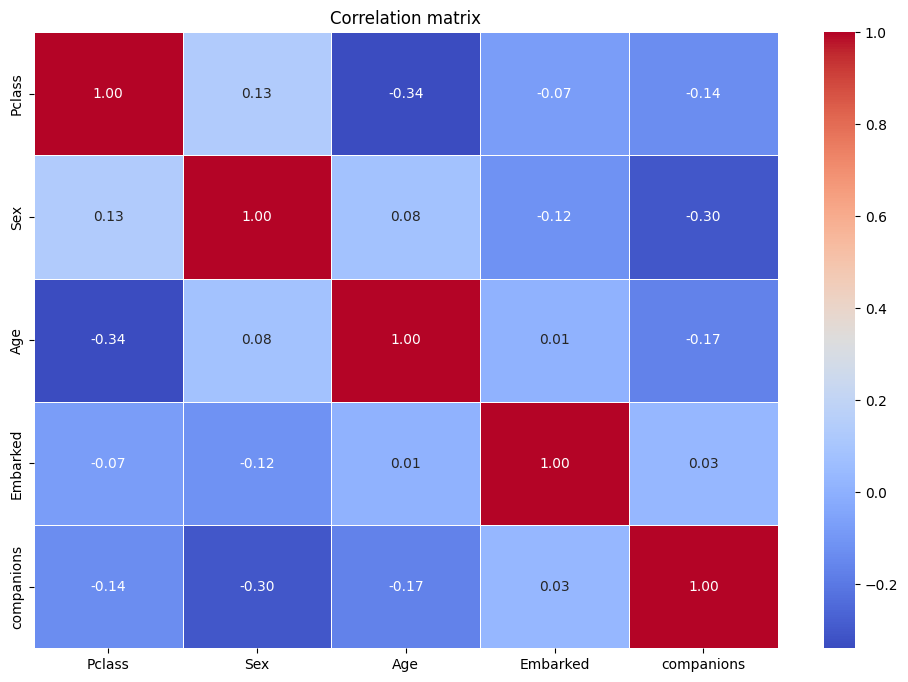

In [243]:
#Correlation matrix after scaling
scaled_df = pd.DataFrame(x_train, columns=x_train.columns) 
correlation_matrix = scaled_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation matrix')
plt.show()

Verify if all the null values are gone and check which columns left

In [244]:
data_frame.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
Embarked      0
companions    0
dtype: int64

**Execute PCA**

In [245]:
data_frame_test.isnull().sum()

Pclass        0
Sex           0
Age           0
Embarked      0
companions    0
dtype: int64

In [246]:
data_frame

,Survived,Pclass,Sex,Age,Embarked,companions
0,0,3,1,22.0,0,1
1,1,1,0,38.0,1,1
2,1,3,0,26.0,0,0
3,1,1,0,35.0,0,1
4,0,3,1,35.0,0,0
...,...,...,...,...,...,...
886,0,2,1,27.0,0,0
887,1,1,0,19.0,0,0
888,0,3,0,28.0,0,1
889,1,1,1,26.0,1,0


In [247]:
# Paso 1: Ejecutar PCA para el conjunto de entrenamiento
pca = PCA() 
X_train_pca = pca.fit_transform(X_train_scaled)
df_pca_train = pd.DataFrame(data=X_train_pca, columns=[f'PC{i+1}' for i in range(X_train_scaled.shape[1])])

# Paso 2: Imprimir los resultados del conjunto de entrenamiento
print("PCA para el conjunto de entrenamiento:")
print(df_pca_train.head())
print("")
print("Varianza explicada por cada componente: ", pca.explained_variance_ratio_)
print("")
print("Varianza total explicada: ", sum(pca.explained_variance_ratio_))


PCA para el conjunto de entrenamiento:
        PC1       PC2       PC3       PC4       PC5
0  0.201859 -1.169564 -0.759662  1.005461  0.669587
1 -2.650074  1.083036  0.801116  0.202102  0.078570
2  0.126462 -0.719680 -0.195153 -1.746379 -0.074096
3 -2.027859  0.738415 -1.276711 -0.189619 -0.225431
4  1.474728  0.072526 -0.194923 -0.268458  0.405997

Varianza explicada por cada componente:  [0.28640036 0.26922739 0.19474855 0.1391717  0.110452  ]

Varianza total explicada:  1.0


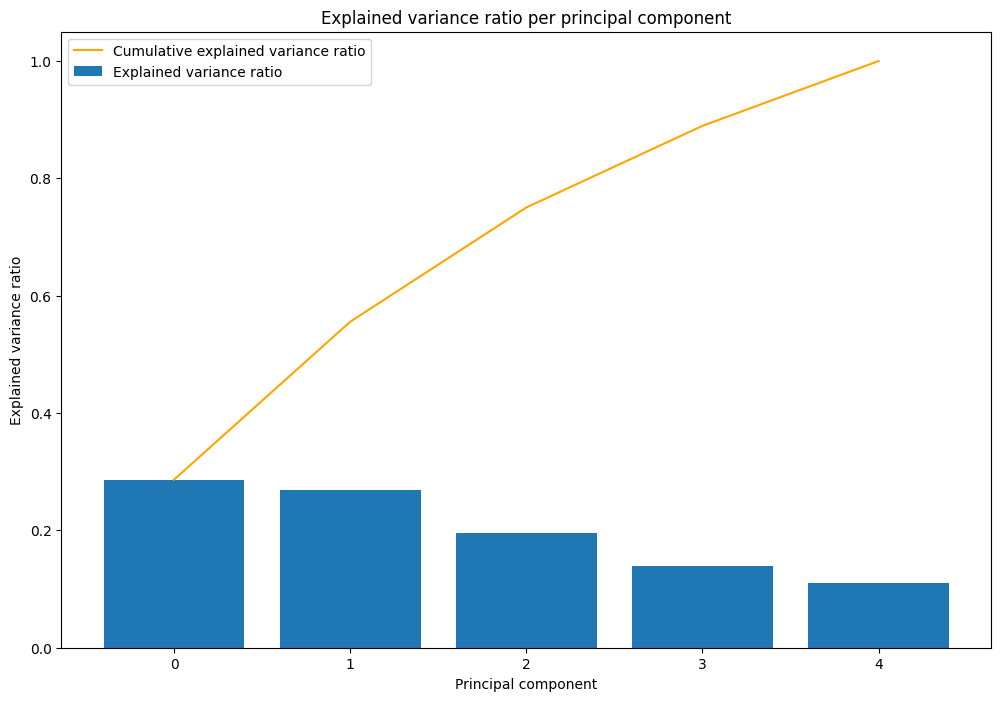

In [248]:
#Plot each column of the PCA

plt.figure(figsize=(12, 8))
plt.bar(range(X_train_scaled.shape[1]), pca.explained_variance_ratio_, label='Explained variance ratio')
plt.plot(range(X_train_scaled.shape[1]), np.cumsum(pca.explained_variance_ratio_), label='Cumulative explained variance ratio', color='orange')
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.title('Explained variance ratio per principal component')
plt.legend()
plt.show()

In [249]:
# Get the loadings for each principal component
loadings = pd.DataFrame(pca.components_, columns=x_train.columns[:])  # Exclude 'Survived' from the columns

# Display the loadings
print("PCA Component Loadings:")
print(loadings)

# Optionally, show the absolute values of the loadings for easier interpretation
print("\nAbsolute Values of PCA Component Loadings:")
print(loadings.abs())

# If you want to see which variable contributes the most to each principal component
for i in range(len(loadings)):
    print(f"\nTop contributing feature(s) to PC{i+1}:")
    print(loadings.iloc[i].nlargest(5))  # Adjust the number of top features as needed

PCA Component Loadings:
     Pclass       Sex       Age  Embarked  companions
0  0.397252  0.630540  0.041027 -0.282042   -0.602809
1 -0.602115  0.132400  0.744683  0.077215   -0.243748
2  0.173129  0.020129 -0.060589  0.933987   -0.305970
3 -0.242739  0.764303 -0.176348  0.193057    0.537168
4  0.625102  0.018041  0.639527  0.069903    0.441634

Absolute Values of PCA Component Loadings:
     Pclass       Sex       Age  Embarked  companions
0  0.397252  0.630540  0.041027  0.282042    0.602809
1  0.602115  0.132400  0.744683  0.077215    0.243748
2  0.173129  0.020129  0.060589  0.933987    0.305970
3  0.242739  0.764303  0.176348  0.193057    0.537168
4  0.625102  0.018041  0.639527  0.069903    0.441634

Top contributing feature(s) to PC1:
Sex           0.630540
Pclass        0.397252
Age           0.041027
Embarked     -0.282042
companions   -0.602809
Name: 0, dtype: float64

Top contributing feature(s) to PC2:
Age           0.744683
Sex           0.132400
Embarked      0.077215
co

In [250]:
# Paso 3: Aplicar PCA al conjunto de prueba usando el modelo ajustado con los datos de entrenamiento
X_test_pca = pca.transform(X_test_scaled)
df_pca_test = pd.DataFrame(data=X_test_pca, columns=[f'PC{i+1}' for i in range(X_test_scaled.shape[1])])

# Paso 4: Imprimir los resultados del conjunto de prueba
print("PCA para el conjunto de prueba:")
print(df_pca_test.head())

PCA para el conjunto de prueba:
        PC1       PC2       PC3       PC4       PC5
0  0.945347  0.162905  1.651647  0.124575  0.544423
1 -0.968500 -0.038846 -1.028866 -0.942714  1.894289
2  0.561813  2.492956  1.314430  0.031064  1.187039
3  1.510859 -0.438725 -0.265550 -0.174880  0.020239
4 -1.049335 -1.506078 -0.909489 -0.595260  0.634243


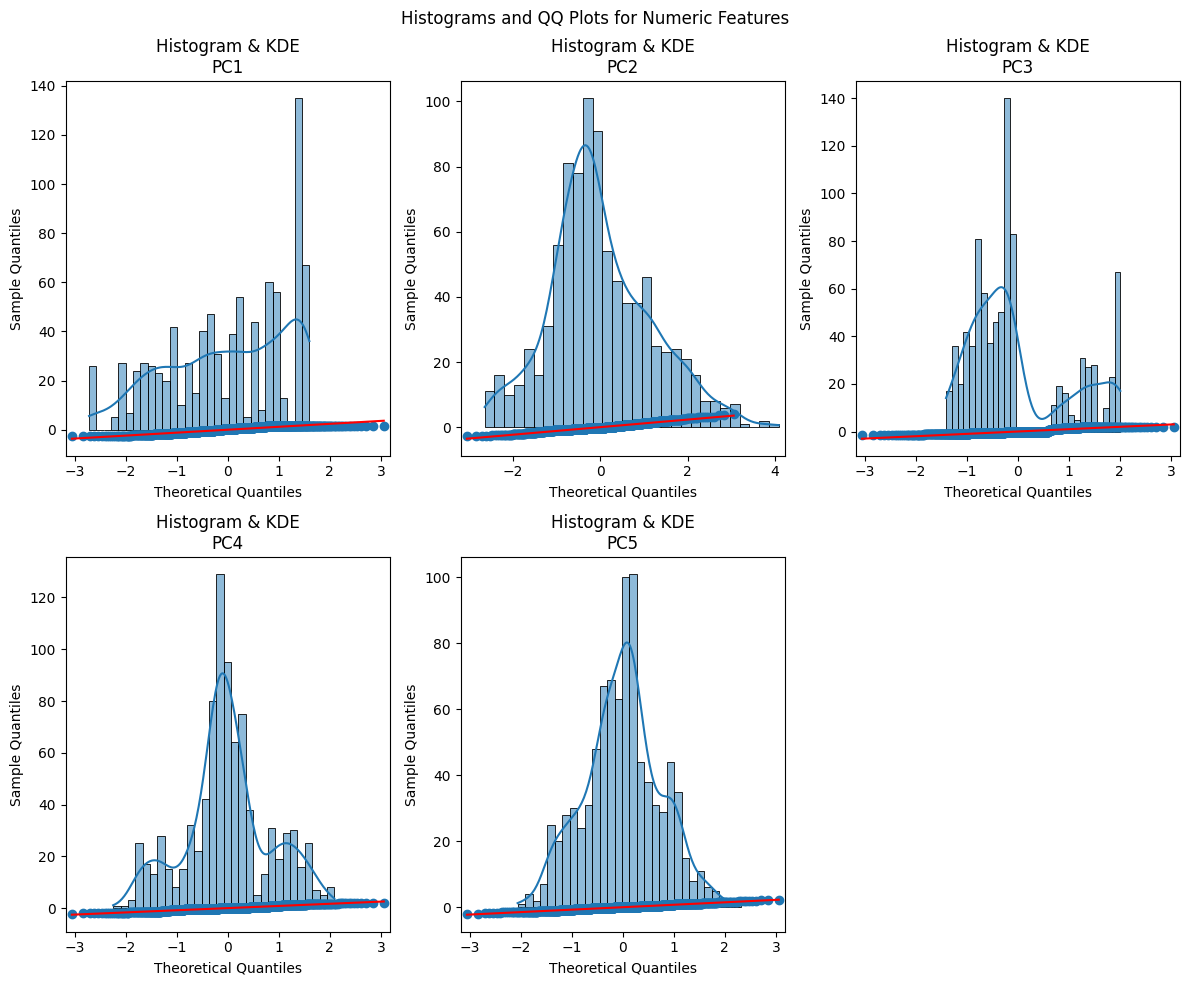

In [251]:
numeric_features = df_pca_train.select_dtypes(include=[np.number]).columns
n_rows, n_cols = 2, len(numeric_features) // 2 + (len(numeric_features) % 2)  # Auto-adjust grid size
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 10))  # Adjust figsize as needed

fig.suptitle('Histograms and QQ Plots for Numeric Features')

feature_index = 0
for row in range(n_rows):
    for col in range(n_cols):
        if feature_index >= len(numeric_features):
            axes[row, col].axis('off')  # Hide unused subplots
            continue

        data = df_pca_train[numeric_features[feature_index]]

        # Histogram
        sns.histplot(data, ax=axes[row, col], kde=True, bins=30)
        axes[row, col].set_title(f'Histogram & KDE\n{numeric_features[feature_index]}')

        # QQ Plot (on the same subplot as the histogram)
        qqplot(data, line='s', ax=axes[row, col])

        feature_index += 1

fig.tight_layout()
plt.show()

# Clasification

In [252]:

df_pca_train=df_pca_train[['PC1', 'PC2', 'PC3', 'PC4']]
df_pca_test=df_pca_test[['PC1', 'PC2', 'PC3', 'PC4']]


In [253]:
print("\nComponentes seleccionadas (PC1, PC2, PC3, PC4):")
print(df_pca_train.head())
print(df_pca_test.head())


Componentes seleccionadas (PC1, PC2, PC3, PC4):
        PC1       PC2       PC3       PC4
0  0.201859 -1.169564 -0.759662  1.005461
1 -2.650074  1.083036  0.801116  0.202102
2  0.126462 -0.719680 -0.195153 -1.746379
3 -2.027859  0.738415 -1.276711 -0.189619
4  1.474728  0.072526 -0.194923 -0.268458
        PC1       PC2       PC3       PC4
0  0.945347  0.162905  1.651647  0.124575
1 -0.968500 -0.038846 -1.028866 -0.942714
2  0.561813  2.492956  1.314430  0.031064
3  1.510859 -0.438725 -0.265550 -0.174880
4 -1.049335 -1.506078 -0.909489 -0.595260


### Random Forest

Justification: Given the Titanic dataset’s diversity in features (like age, fare, class, etc.), Random Forest can effectively capture the non-linear relationships between features and survival.

Justificar cada uno de los hyperparametros
    - Slide oculto
    - Graficas de cada hyper y para anexos

In [254]:
# Define the parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [5, 10, 15],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4], # Minimum samples required for node
    'max_features': ['auto', 'sqrt', 'log2'], # Features considered at each split
}

# Create a Random Forest Classifier object
rf = RandomForestClassifier()

# Perform Grid Search with cross-validation
grid_search_rf = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy')  # Adjust 'scoring' as needed
grid_search_rf.fit(df_pca_train, y_train)

c:\Users\danyO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
405 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\danyO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\danyO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\danyO\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\bas

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [5, 10, 15],
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [255]:
best_model_rf = grid_search_rf.best_estimator_
best_params = grid_search_rf.best_params_

print("Best Hyperparameters:", best_params)
# Make predictions using the best model (consider using hold-out validation for better evaluation)
y_pred = best_model_rf.predict(df_pca_test)

Best Hyperparameters: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


In [272]:
# Crear un array para almacenar la suma de las matrices de confusión
conf_matrix_sum = np.zeros((2, 2))  # Para un problema binario (Survived = 0 o 1)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
pipeline = make_pipeline(StandardScaler(), best_model_rf)
accuracies_rf=[]
classification_reports_rf=[]
metrics_sum = {
    'precision': [],
    'recall': [],
    'f1-score': []
}

auc_scores = []  

for train_index, test_index in kf.split(df_pca_train):
    # Separar los datos de entrenamiento y prueba para este fold
    X_train_fold, X_test_fold = df_pca_train.iloc[train_index], df_pca_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Ajustar el pipeline en los datos de entrenamiento del fold actual
    pipeline.fit(X_train_fold, y_train_fold)
    # Predecir en los datos de prueba del fold actual
    y_pred_fold = pipeline.predict(X_test_fold)
    y_pred_proba_fold = pipeline.predict_proba(X_test_fold)[:, 1]  # Probabilidades para la clase positiva
    
    # Calcular el AUC para este fold
    auc_fold = roc_auc_score(y_test_fold, y_pred_proba_fold)
    auc_scores.append(auc_fold)

    # Calcular el score para este fold y agregarlo a la lista de accuracies_lg
    accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
    accuracies_rf.append(accuracy_fold)
    
    # Calcular la matriz de confusión para este fold
    conf_matrix_fold = confusion_matrix(y_test_fold, y_pred_fold)
    
    # Sumar la matriz de confusión actual a la suma total
    conf_matrix_sum += conf_matrix_fold

    classification_report_fold = classification_report(y_test_fold, y_pred_fold, output_dict=True)
    classification_reports_rf.append(classification_report_fold)
    metrics_sum['precision'].append(classification_report_fold['weighted avg']['precision'])
    metrics_sum['recall'].append(classification_report_fold['weighted avg']['recall'])
    metrics_sum['f1-score'].append(classification_report_fold['weighted avg']['f1-score'])

    

# Promediar la matriz de confusión dividiendo entre el número de folds
conf_matrix_avg_rf = conf_matrix_sum / kf.get_n_splits()

# Mostrar la matriz de confusión promedio
print("Matriz de confusión promedio:")
print(conf_matrix_avg_rf)



Matriz de confusión promedio:
[[99.8 10. ]
 [24.4 44. ]]


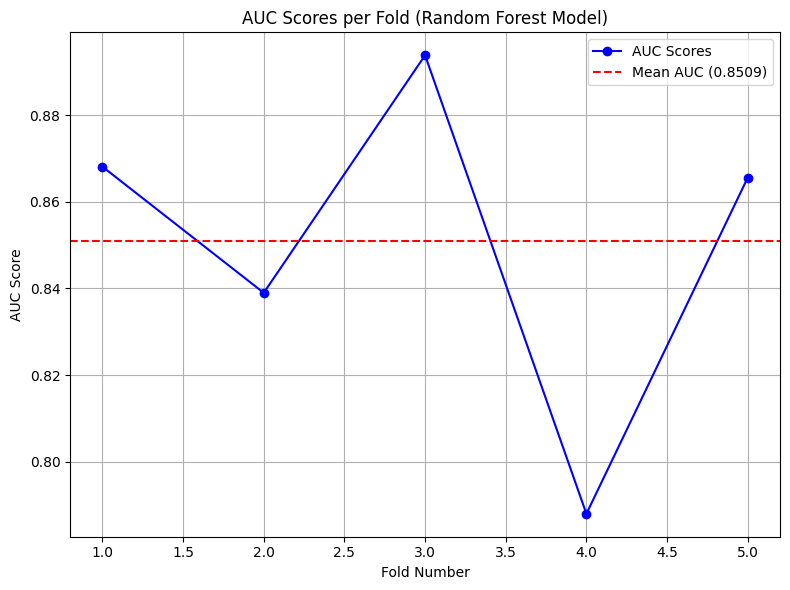

In [273]:
# Calculate average AUC
mean_auc = np.mean(auc_scores)

# Prepare data for visualization (assuming 5 folds)
fold_numbers = range(1, len(auc_scores) + 1)  # Folds 1 to 5

# Create the AUC plot
plt.figure(figsize=(8, 6))
plt.plot(fold_numbers, auc_scores, marker='o', linestyle='-', color='b', label='AUC Scores')
plt.axhline(y=mean_auc, color='r', linestyle='--', label=f'Mean AUC ({mean_auc:.4f})')

plt.xlabel('Fold Number')
plt.ylabel('AUC Score')
plt.title('AUC Scores per Fold (Random Forest Model)')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [257]:
print(f"Accuracy por fold: {accuracies_rf}")
print(f"Accuracy promedio: {np.mean(accuracies_rf)}")

Accuracy por fold: [0.8044692737430168, 0.7921348314606742, 0.8595505617977528, 0.7640449438202247, 0.8258426966292135]
Accuracy promedio: 0.8092084614901764


In [258]:
precision_avg = np.mean(metrics_sum['precision'])
recall_avg = np.mean(metrics_sum['recall'])
f1_score_avg = np.mean(metrics_sum['f1-score'])

print(f"Precision promedio: {precision_avg}")
print(f"Recall promedio: {recall_avg}")
print(f"F1-Score promedio: {f1_score_avg}")

Precision promedio: 0.8105057664005786
Recall promedio: 0.8092084614901764
F1-Score promedio: 0.8035531694133073


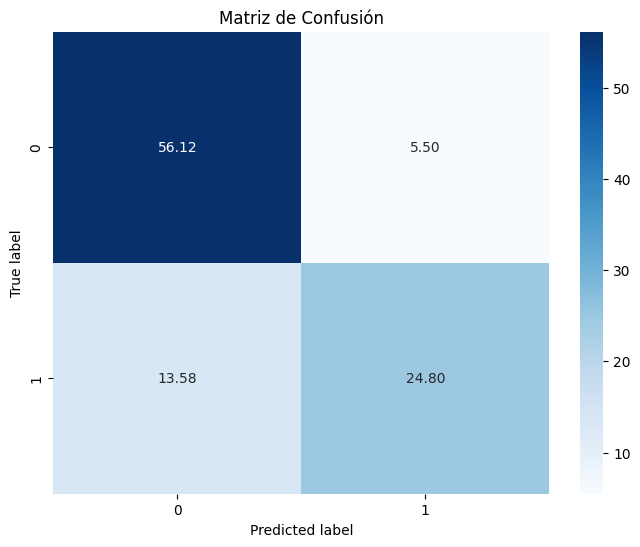

In [259]:
# Visualiza la matriz de confusión
conf_matrix_avg= conf_matrix_avg_rf / conf_matrix_avg_rf.sum()*100
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_avg, annot=True, fmt=".2F", cmap="Blues")
plt.title("Matriz de Confusión")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Logistic Regression

In [260]:
model_lr = LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.5, max_iter=1000)
model_lr.fit(df_pca_train, y_train)

LogisticRegression(l1_ratio=0.5, max_iter=1000, penalty='elasticnet',
                   solver='saga')

> Usar robustez, fortaleza, etc -> mucho cuidado, apoyar con graficas si se utilizan en presentacion  
> Ir mas por el lado de rendimiento (Contexto de en que situaciones, problemas binarios, etc)

> Contexto datos lineales

In [261]:

coefficients = model_lr.coef_[0]  # Since it's binary, we have only one set of coefficients
intercept = model_lr.intercept_[0]  # Single intercept for binary classification
feature_names = df_pca_train.columns


# Output the linear function with feature names
print(f"Linear function:")
print(f"y = {intercept:.3f} + ", end="")
for j, coef in enumerate(coefficients):
    print(f"({coef:.3f} * {feature_names[j]})", end=" ")
    if j != len(coefficients) - 1:
        print("+ ", end="") 
print("\n")

Linear function:
y = -0.614 + (-1.127 * PC1) + (0.132 * PC2) + (0.043 * PC3) + (-0.550 * PC4) 



In [262]:
# Crear un array para almacenar la suma de las matrices de confusión
conf_matrix_sum = np.zeros((2, 2))  # Para un problema binario (Survived = 0 o 1)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
pipeline = make_pipeline(StandardScaler(), model_lr)
accuracies_lr=[]
classification_reports_lr=[]
metrics_sum = {
    'precision': [],
    'recall': [],
    'f1-score': []
}
for train_index, test_index in kf.split(df_pca_train):
    # Separar los datos de entrenamiento y prueba para este fold
    X_train_fold, X_test_fold = df_pca_train.iloc[train_index], df_pca_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Ajustar el pipeline en los datos de entrenamiento del fold actual
    pipeline.fit(X_train_fold, y_train_fold)
    # Predecir en los datos de prueba del fold actual
    y_pred_fold = pipeline.predict(X_test_fold)
    
    # Calcular el score para este fold y agregarlo a la lista de accuracies_lr
    accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
    accuracies_lr.append(accuracy_fold)
    
    # Calcular la matriz de confusión para este fold
    conf_matrix_fold = confusion_matrix(y_test_fold, y_pred_fold)
    
    # Sumar la matriz de confusión actual a la suma total
    conf_matrix_sum += conf_matrix_fold

    classification_report_fold = classification_report(y_test_fold, y_pred_fold, output_dict=True)
    classification_reports_lr.append(classification_report_fold)
    metrics_sum['precision'].append(classification_report_fold['weighted avg']['precision'])
    metrics_sum['recall'].append(classification_report_fold['weighted avg']['recall'])
    metrics_sum['f1-score'].append(classification_report_fold['weighted avg']['f1-score'])

    

# Promediar la matriz de confusión dividiendo entre el número de folds
conf_matrix_avg_lr = conf_matrix_sum / kf.get_n_splits()

# Mostrar la matriz de confusión promedio
print("Matriz de confusión promedio:")
print(conf_matrix_avg_lr)



Matriz de confusión promedio:
[[91.6 18.2]
 [21.2 47.2]]


In [263]:
print(f"Accuracy por fold: {accuracies_lr}")
print(f"Accuracy promedio: {np.mean(accuracies_lr)}")

Accuracy por fold: [0.770949720670391, 0.7528089887640449, 0.8314606741573034, 0.7359550561797753, 0.8033707865168539]
Accuracy promedio: 0.7789090452576738


In [264]:
precision_avg = np.mean(metrics_sum['precision'])
recall_avg = np.mean(metrics_sum['recall'])
f1_score_avg = np.mean(metrics_sum['f1-score'])

print(f"Precision promedio: {precision_avg}")
print(f"Recall promedio: {recall_avg}")
print(f"F1-Score promedio: {f1_score_avg}")

Precision promedio: 0.7772033488595314
Recall promedio: 0.7789090452576738
F1-Score promedio: 0.7776903522029545


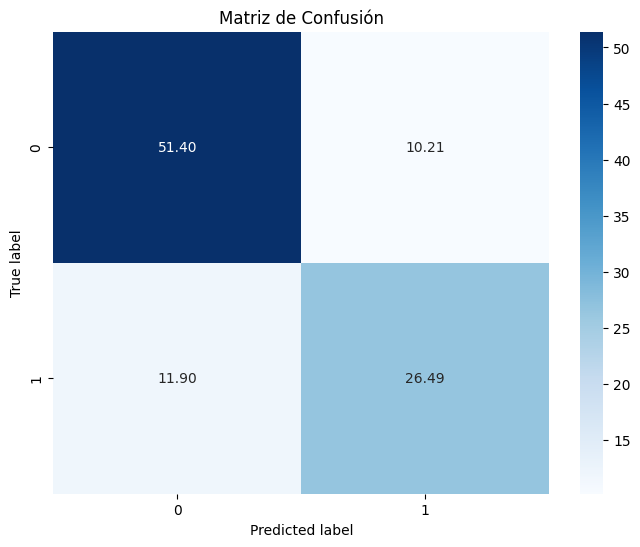

In [265]:
# Visualiza la matriz de confusión
conf_matrix_avg= conf_matrix_avg_lr / conf_matrix_avg_lr.sum()*100
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_avg, annot=True, fmt=".2F", cmap="Blues")
plt.title("Matriz de Confusión")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

SVM

In [266]:
model_svm = SVC()
param_grid = {
    'C':[1,2,5,10,20,50],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear']
} 
grs = GridSearchCV(model_svm, param_grid=param_grid, cv = 10, n_jobs=1, return_train_score = False, scoring='accuracy')
grs.fit(np.array(df_pca_train), np.array(y_train))

GridSearchCV(cv=10, estimator=SVC(), n_jobs=1,
             param_grid={'C': [1, 2, 5, 10, 20, 50],
                         'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             scoring='accuracy')

In [267]:
print("Best parameters " + str(grs.best_params_))
gpd = pd.DataFrame(grs.cv_results_)
print("Estimated accuracy of this model for unseen data:{0:1.4f}".format(gpd['mean_test_score'][grs.best_index_]))

Best parameters {'C': 50, 'gamma': 0.1, 'kernel': 'rbf'}
Estimated accuracy of this model for unseen data:0.8137


1. Gamma (gamma)

Influencia de los puntos de entrenamiento: gamma define qué tan lejos llega la influencia de un solo punto de entrenamiento.
Un valor bajo de gamma significa una influencia más amplia, lo que resulta en un modelo más suave que captura patrones más generales en los datos.
Un valor alto de gamma significa una influencia más localizada, lo que resulta en un modelo más complejo que se ajusta más estrechamente a los puntos de entrenamiento individuales.
Relación con el sobreajuste:
Un gamma demasiado alto puede llevar a un sobreajuste, donde el modelo se adapta demasiado bien a los datos de entrenamiento y tiene un rendimiento deficiente en datos nuevos.
Un gamma demasiado bajo puede llevar a un subajuste, donde el modelo es demasiado simple para capturar la complejidad de los datos.

2. Kernel (kernel)

Función de transformación: El kernel define la función matemática utilizada para transformar los datos de entrada en un espacio de mayor dimensión, donde se puede encontrar un hiperplano lineal que separa las clases.
Kernel RBF ('rbf'): El kernel de función de base radial (RBF) es uno de los kernels más populares en SVM. Crea un espacio de características de dimensión infinita, lo que permite al modelo aprender relaciones no lineales complejas en los datos.

3. C (C)

Regularización: C controla el equilibrio entre maximizar el margen entre las clases y minimizar el error de clasificación en los datos de entrenamiento.
Relación con el sobreajuste y el subajuste:
Un valor alto de C penaliza fuertemente los errores de clasificación, lo que puede llevar a un margen más estrecho y potencialmente a un sobreajuste.
Un valor bajo de C permite un margen más amplio pero puede llevar a una mayor clasificación errónea de los puntos de entrenamiento y potencialmente a un subajuste.



Gamma (gamma)

"A Practical Guide to Support Vector Classification" por Chih-Wei Hsu, Chih-Chung Chang y Chih-Jen Lin: Este artículo ampliamente citado proporciona una guía práctica para la clasificación con SVM, incluyendo una discusión detallada sobre la selección de gamma.

Kernel (kernel)

"An Introduction to Support Vector Machines and Other Kernel-based Learning Methods" por Nello Cristianini y John Shawe-Taylor: Este libro ofrece una introducción completa a los SVM y otros métodos de aprendizaje basados en kernels, incluyendo una explicación detallada de diferentes tipos de kernels y cómo elegir el kernel adecuado para un problema específico.

C (C)

"Support Vector Networks" por Corinna Cortes y Vladimir Vapnik: Este artículo fundamental presenta el concepto de SVM y discute el papel del parámetro C en el control de la complejidad del modelo y la prevención del sobreajuste.

Además de estos recursos, también puedes buscar artículos científicos relevantes en bases de datos como:



kernel: 'rbf': El kernel RBF fue seleccionado como el mejor, lo que sugiere que los datos tienen relaciones no lineales que el modelo necesita capturar.
C: 2: Este valor indica un nivel moderado de regularización. El modelo está dispuesto a tolerar algunos errores de clasificación en los datos de entrenamiento para lograr un mejor margen y una mejor generalización.
gamma: 0.1: Este valor sugiere que la influencia de cada punto de entrenamiento es relativamente amplia, lo que ayuda al modelo a capturar patrones más generales en los datos.

In [268]:
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

# Crear un array para almacenar la suma de las matrices de confusión
conf_matrix_sum = np.zeros((2, 2))  # Para un problema binario (Survived = 0 o 1)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
pipeline = make_pipeline(StandardScaler(), grs)
accuracies_svm=[]
for train_index, test_index in kf.split(df_pca_train):
    # Separar los datos de entrenamiento y prueba para este fold
    X_train_fold, X_test_fold = df_pca_train.iloc[train_index], df_pca_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    # Ajustar el pipeline en los datos de entrenamiento del fold actual
    pipeline.fit(X_train_fold, y_train_fold)
    # Predecir en los datos de prueba del fold actual
    y_pred_fold = pipeline.predict(X_test_fold)
    
    # Calcular el score para este fold y agregarlo a la lista de accuracies_svm
    accuracy_fold = accuracy_score(y_test_fold, y_pred_fold)
    accuracies_svm.append(accuracy_fold)
    
    # Calcular la matriz de confusión para este fold
    conf_matrix_fold = confusion_matrix(y_test_fold, y_pred_fold)
    
    # Sumar la matriz de confusión actual a la suma total
    conf_matrix_sum += conf_matrix_fold

# Promediar la matriz de confusión dividiendo entre el número de folds
conf_matrix_avg_svm = conf_matrix_sum / kf.get_n_splits()

# Mostrar la matriz de confusión promedio
print("Matriz de confusión promedio:")
print(conf_matrix_avg_svm)


Matriz de confusión promedio:
[[103.    6.8]
 [ 25.4  43. ]]


In [269]:
print(f"Accuracy por fold: {accuracies_svm}")
print(f"Accuracy promedio: {np.mean(accuracies_svm)}")

Accuracy por fold: [0.7988826815642458, 0.8146067415730337, 0.8595505617977528, 0.7808988764044944, 0.8426966292134831]
Accuracy promedio: 0.819327098110602


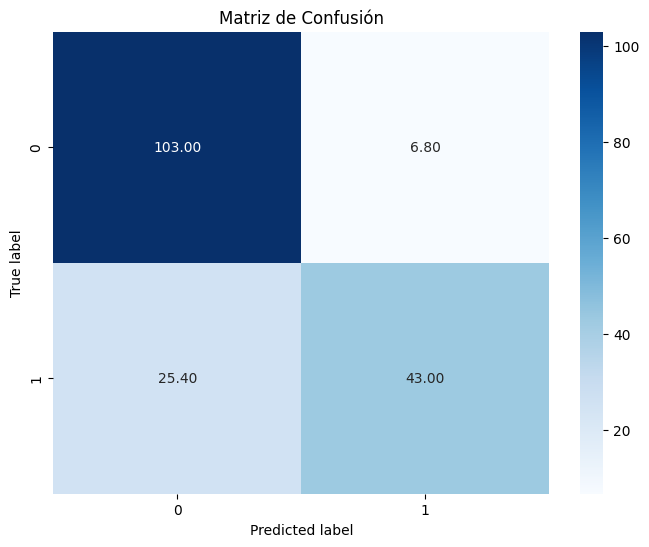

In [270]:
# Visualiza la matriz de confusión
conf_matrix_avg= conf_matrix_avg_svm / conf_matrix_avg.sum()*100
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_avg, annot=True, fmt=".2F", cmap="Blues")
plt.title("Matriz de Confusión")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Explicar BIEN los pasos para seleccionar el modelo final  
Explicar bien los objetivos (se ajusta, minimo accuracy)

Alinearlo con conclusiones

Kernel justificar con svm
Normalmente - gauss
Fortalezas de cada uno y justificar de cada uno

Google scholar
Transformada mas utilizada (mejores resultados)

Corrida varias veces y sacar el promedio

Promedios de cada uno estaria bien :)


K fold cross validation
Cada uno

En vez de mostrar accuracy, mostrar el promedio

1 o 3 Discutir


Discusion de resultados
Accuracy de cada uno

Pelea antes de concluir

Conclusiones
Se cumplio lo que esperaba